In [1]:
import pandas as pd
import numpy as np

In [91]:
import itertools

In [2]:
import pickle

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score,  recall_score, precision_score


In [124]:
from src.my_metr import plot_roc_curve

In [125]:
from src.trans_rat import FillPrice, CategoriesTransformScr, RatingNormalizer, FillPriceScr


In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from pymongo import MongoClient
import time
from bs4 import BeautifulSoup

mc = MongoClient()
db  = mc['raw_restaurants']
rv_s = db['reviews_scrap']

In [89]:
from src.plot_confm import plot_confusion_matrix

In [9]:
colClust_n = ['cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4', 'cl_t5',  'cl_t7',
       'cl_t8', 'cl_t9', 'cl_t10', 'cl_t11', 'cl_t12', 'cl_t13', 'cl_t14',
        'cl_t16', 'cl_t17']

In [10]:
#numbers_list = pickle.load(list_unpickle)

In [11]:
clust_model_rf ={}
clust_model_gr = {}

In [12]:
for col in colClust_n:
    filename_gr = 'grboost/mgr_'+col+'.pkl'
    with open(filename_gr,'rb') as f:
        clust_model_gr[col]= pickle.load( f)
    filename_rf = 'rforest/mrf_'+col+'.pkl'
    with open(filename_rf,'rb') as f:
        clust_model_rf[col] =pickle.load( f)

In [13]:
clust_model_gr['cl_t3']

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=179, subsample=0.8, verbose=0,
              warm_start=False)

In [14]:
user_cl = pd.read_csv('user_from_scr_clidf18.csv')

In [15]:
rest = db['restaurants']

rest_df = pd.DataFrame(list(rest.find({})))

In [16]:
rest_df.shape

(12615, 18)

### надо почистить дату

In [17]:
revs_df = pd.DataFrame(list(rv_s.find({})))

In [18]:
revs_df.columns

Index(['_id', 'alias', 'biz_id', 'category', 'date', 'id', 'rating', 'text',
       'user_id'],
      dtype='object')

In [19]:
revs_df.drop(columns=[ '_id', 'category', 'date'], inplace= True)

In [20]:
rest_alias = np.unique(revs_df.alias)

In [21]:
len(rest_alias)

10222

In [22]:
act = (revs_df.rating.astype(float) < 3)

In [23]:
rest_df.head(3)

,_id,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,rev_API,review_count,transactions,url
0,5bf90d4e7988471b045ba501,maono-seattle,"[{'alias': 'hawaiian', 'title': 'Hawaiian'}, {...","{'latitude': 47.5636486287425, 'longitude': -1...",(206) 935-1075,1501.527536,gDAO-4m63svPUpii5b8kww,https://s3-media4.fl.yelpcdn.com/bphoto/rwJG59...,False,"{'address1': '4437 California Ave SW', 'addres...",Ma'ono,+12069351075,$$,4.0,1,788,[],https://www.yelp.com/biz/maono-seattle?adjust_...
1,5bf90d4e7988471b045ba502,ohs-sandwiches-seattle-2,"[{'alias': 'sandwiches', 'title': 'Sandwiches'...","{'latitude': 47.5751165, 'longitude': -122.387...",(206) 420-3692,2616.713742,xzLAynrVb3No3ADUhMxlnQ,https://s3-media2.fl.yelpcdn.com/bphoto/zKlK95...,False,"{'address1': '3217 California Ave SW', 'addres...",Oh's Sandwiches,+12064203692,NaN,4.5,1,32,[],https://www.yelp.com/biz/ohs-sandwiches-seattl...
2,5bf90d4e7988471b045ba503,marination-ma-kai-seattle,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...","{'latitude': 47.5895547295386, 'longitude': -1...",(206) 328-8226,4061.556690,IsvlaFF0EPEhh3ahTuC4xg,https://s3-media1.fl.yelpcdn.com/bphoto/r19fwm...,False,"{'address1': '1660 Harbor Ave SW', 'address2':...",Marination Ma Kai,+12063288226,$$,4.0,1,897,[],https://www.yelp.com/biz/marination-ma-kai-sea...


In [24]:
rest_clean = rest_df.drop(columns= ['_id','coordinates', 'display_phone', 
                                    'distance','image_url', 'name','location',
                                   'is_closed','phone', 'transactions','url'])

In [25]:
rest_clean.head(3)

,alias,categories,id,price,rating,rev_API,review_count
0,maono-seattle,"[{'alias': 'hawaiian', 'title': 'Hawaiian'}, {...",gDAO-4m63svPUpii5b8kww,$$,4.0,1,788
1,ohs-sandwiches-seattle-2,"[{'alias': 'sandwiches', 'title': 'Sandwiches'...",xzLAynrVb3No3ADUhMxlnQ,NaN,4.5,1,32
2,marination-ma-kai-seattle,"[{'alias': 'korean', 'title': 'Korean'}, {'ali...",IsvlaFF0EPEhh3ahTuC4xg,$$,4.0,1,897


In [25]:
#Pipeline = Pipeline([FillPriceScr, CategoriesTransformScr, RatingNormalizer ])


In [26]:
fpr = FillPriceScr()

In [27]:
rest_cl2 = fpr.transform(rest_clean)
rest_cl2.head(2)

/Users/olga/yelper/trans_rat.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[self.priceCol][pd.isnull(X[self.priceCol])] = '$$'


,alias,categories,id,RestaurantsPriceRange2,rating,rev_API,review_count,rest_isna
0,maono-seattle,"[{'alias': 'hawaiian', 'title': 'Hawaiian'}, {...",gDAO-4m63svPUpii5b8kww,2,4.0,1,788,False
1,ohs-sandwiches-seattle-2,"[{'alias': 'sandwiches', 'title': 'Sandwiches'...",xzLAynrVb3No3ADUhMxlnQ,2,4.5,1,32,True


In [28]:
##Acai Bowls
mod_cat = pd.read_csv('model_cat.csv')
mod_cat.head(3)

,Unnamed: 0,0
0,Acai Bowls,0.000840
1,Active Life,0.004093
2,Afghan,0.002064


In [29]:
mod_fe = mod_cat.iloc[:,0].tolist()
rest_cl2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12615 entries, 0 to 12614
Data columns (total 8 columns):
alias                     12615 non-null object
categories                12615 non-null object
id                        12615 non-null object
RestaurantsPriceRange2    12615 non-null int64
rating                    12615 non-null float64
rev_API                   8945 non-null object
review_count              12615 non-null int64
rest_isna                 12615 non-null bool
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 702.3+ KB


In [30]:
ct = CategoriesTransformScr(mod_fe)
rn = RatingNormalizer(starCol = 'rating')
rest_cx = rn.transform(ct.transform(rest_cl2))
rest_cx.head()

,alias,id,RestaurantsPriceRange2,stars,rev_API,review_count,rest_isna,Acai Bowls,Active Life,Afghan,...,Venues & Event Spaces,Vietnamese,Waffles,Whiskey Bars,Wine & Spirits,Wine Bars,Wineries,Wraps,num_of_categ,st_over_am
0,maono-seattle,gDAO-4m63svPUpii5b8kww,2,4.0,1,788,False,False,False,False,...,False,False,False,False,False,False,False,False,2,0.016000
1,ohs-sandwiches-seattle-2,xzLAynrVb3No3ADUhMxlnQ,2,4.5,1,32,True,False,False,False,...,False,False,False,False,False,False,False,False,2,0.140621
2,marination-ma-kai-seattle,IsvlaFF0EPEhh3ahTuC4xg,2,4.0,1,897,False,False,False,False,...,False,False,False,False,False,False,False,False,3,0.016000
3,ittos-tapas-seattle-4,Dr9CxgdePozHGwU4beaYGQ,2,4.5,1,221,False,False,False,False,...,False,False,False,False,False,False,False,False,3,0.020362
4,pizzeria-credo-seattle,BeGo3TSuhF7fOv0dzp0s1g,2,4.5,1,405,False,False,False,False,...,False,False,False,False,False,False,False,False,2,0.018000


In [31]:
### i forgot to include review_count to model when train
colPred1 = rest_cx.columns[2:4].union( rest_cx.columns[6:])

In [32]:
with open('colPred213', 'rb') as f:
    colPred = pickle.load(f)

In [33]:
colPred[colPred != colPred1]

Index([], dtype='object')

In [34]:
colPred1[colPred != colPred1]

Index([], dtype='object')

In [36]:
colPred1

Index(['Acai Bowls', 'Active Life', 'Afghan', 'African', 'American (New)',
       'American (Traditional)', 'Arabian', 'Arcades', 'Argentine',
       'Art Galleries',
       ...
       'Waffles', 'Whiskey Bars', 'Wine & Spirits', 'Wine Bars', 'Wineries',
       'Wraps', 'num_of_categ', 'rest_isna', 'st_over_am', 'stars'],
      dtype='object', length=213)

In [35]:
X = rest_cx[colPred]

## Restaurants Prediction
make 2 dictionary, then 2 dataframe with cluster predictions

In [36]:
%%time
Y_rf = pd.DataFrame()
Y_gr = pd.DataFrame()
Y_rf['alias'] = rest_cx['alias']
Y_gr['alias'] = rest_cx['alias']
for col in colClust_n:
    Y_rf[col] = clust_model_rf[col].predict_proba(X)[:,1]
    Y_gr[col] = clust_model_gr[col].predict_proba(X)[:,1]


CPU times: user 18.9 s, sys: 1.39 s, total: 20.3 s
Wall time: 11.9 s


In [37]:
Y_gr['rating'] = rest_cx.stars
Y_rf['rating'] = rest_cx.stars


In [38]:
user_cl.head()

,Unnamed: 0,user_id,user_cl
0,0,MVb93PtUPbSsVFa-3prvcg,2
1,1,6XwhYkbgsPZNQLLvTWIc3Q,2
2,2,Re5H1w9VR-YqlKL-ydOlOg,0
3,3,havBggvuzfE6IPfkT-njbg,1
4,4,_efP61KpqeC9K4TX0aqwyw,2


In [39]:
user_cl.shape, user_cl.columns


((385, 3), Index(['Unnamed: 0', 'user_id', 'user_cl'], dtype='object'))

In [40]:
for col in colClust_n:
    i = int(col[4:])
    u_col = 'u'+col
    user_cl[u_col] = (user_cl['user_cl']==i)
 

In [41]:
user_cl.head()

,Unnamed: 0,user_id,user_cl,ucl_t0,ucl_t1,ucl_t2,ucl_t3,ucl_t4,ucl_t5,ucl_t7,ucl_t8,ucl_t9,ucl_t10,ucl_t11,ucl_t12,ucl_t13,ucl_t14,ucl_t16,ucl_t17
0,0,MVb93PtUPbSsVFa-3prvcg,2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,6XwhYkbgsPZNQLLvTWIc3Q,2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,Re5H1w9VR-YqlKL-ydOlOg,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,havBggvuzfE6IPfkT-njbg,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,_efP61KpqeC9K4TX0aqwyw,2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [42]:
   
user_cl_n = user_cl.drop(columns=['Unnamed: 0','user_cl'])
user_cl_n = user_cl_n.groupby('user_id').sum()
user_cl_n.head()

,ucl_t0,ucl_t1,ucl_t2,ucl_t3,ucl_t4,ucl_t5,ucl_t7,ucl_t8,ucl_t9,ucl_t10,ucl_t11,ucl_t12,ucl_t13,ucl_t14,ucl_t16,ucl_t17
user_id,,,,,,,,,,,,,,,,
-KlnVOvjklQn5OpTbxFGzA,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
-Yb1srF4RYtpn-6Yp8ojRg,True,True,True,False,True,False,True,False,True,False,True,False,False,False,False,False
1SVDSLiWxbWmBjenfDQkbA,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False
1Vq3xObhRXBU8gnPIN9jsQ,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2wdhN8Y2EJRswvkduFxnOQ,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True


In [49]:
user_cl_n.shape

(99, 16)

In [50]:
revs_df.head()

,alias,biz_id,id,rating,text,user_id
0,srivilai-thai-cuisine-seattle,NaN,ErsYo_9v8--feFCy92tymQ,5.0,Fantastic Thai food with warm service. Authent...,_3KTfz0hcPl_yq4jOyOPiA
1,ohs-sandwiches-seattle-2,NaN,W1NnSItt-SwWHrzkRtZ44g,5.0,Fantastic Vietnamese sandwich: great flavors a...,_3KTfz0hcPl_yq4jOyOPiA
2,saison-san-francisco-2,NaN,3Q5uzROHYl1i2B_t2sIl7w,3.0,A fine dining restaurant that is in the midst ...,_3KTfz0hcPl_yq4jOyOPiA
3,international-smoke-san-francisco-2,NaN,-GYe-Aq7NcNJ3u-U6fmwMg,5.0,Great restaurant with an interesting mix of in...,_3KTfz0hcPl_yq4jOyOPiA
4,supercuts-san-francisco,NaN,pPlsW81ntC2qbF0QOe6pLQ,5.0,We always have a good experience here with Ani...,_3KTfz0hcPl_yq4jOyOPiA


In [43]:
rev_user = revs_df.join(user_cl_n, on = 'user_id', how = 'right')

In [44]:
rev_user.shape

(12563, 22)

In [45]:
rev_user_biz_gr = rev_user.merge(Y_gr, on = 'alias')

In [46]:
rev_user_biz_rf = rev_user.merge(Y_rf, on = 'alias')

In [47]:
rev_user_biz_gr.head(3)

,alias,biz_id,id,rating_x,text,user_id,ucl_t0,ucl_t1,ucl_t2,ucl_t3,...,cl_t8,cl_t9,cl_t10,cl_t11,cl_t12,cl_t13,cl_t14,cl_t16,cl_t17,rating_y
0,srivilai-thai-cuisine-seattle,NaN,ErsYo_9v8--feFCy92tymQ,5.0,Fantastic Thai food with warm service. Authent...,_3KTfz0hcPl_yq4jOyOPiA,True,True,False,False,...,0.002361,0.006865,0.000325,0.011974,0.000438,0.003589,0.0,0.030197,0.003987,4.5
1,srivilai-thai-cuisine-seattle,iJjKL0KxMZJCb8MmAsERvA,_oJOAI1Agf5uSbQrT6gS0A,5.0,Today is my 3rd visit and I'm pleased. The di...,iJjKL0KxMZJCb8MmAsERvA,True,True,False,False,...,0.002361,0.006865,0.000325,0.011974,0.000438,0.003589,0.0,0.030197,0.003987,4.5
2,srivilai-thai-cuisine-seattle,3DLg6FHxYaueFO-47can0w,OaaR9v40Id6czlxw6vicTg,4.0,My boyfriend and I came here last week to cele...,3DLg6FHxYaueFO-47can0w,True,True,False,False,...,0.002361,0.006865,0.000325,0.011974,0.000438,0.003589,0.0,0.030197,0.003987,4.5


In [48]:
with open('thres_35_gr', 'rb') as f:
    th_gr35 = pickle.load(f)
with open('thres_35_rf','rb') as f:
    th_rf35 = pickle.load(f )

In [49]:
def predict_rating(row, colClust_n, thres):
    r = False
    for col in colClust_n:
        u_col = 'u'+col
        if row[u_col] and row[col] >= thres[col]:
            r = True
    return r

In [50]:
pred_gr = rev_user_biz_gr.apply(predict_rating, axis=1, args = (colClust_n, th_gr35))

In [51]:
pred_rf = rev_user_biz_rf.apply(predict_rating, axis=1, args = (colClust_n, th_rf35))

In [52]:
act = (rev_user_biz_gr['rating_x'].astype(float) <3)

In [53]:
act_plus = (rev_user_biz_gr['rating_x'].astype(float) <4)

In [54]:
base35 = (rev_user_biz_gr['rating_y'].astype(float) <3.5)
base4 = (rev_user_biz_gr['rating_y'].astype(float) <4)
base45 = (rev_user_biz_gr['rating_y'].astype(float) <4.5)
base5 = (rev_user_biz_gr['rating_y'].astype(float) <5)


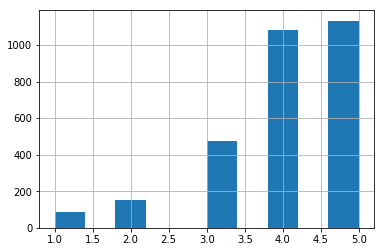

In [105]:
rev_user_biz_rf[~base4]['rating_x'].astype(float).hist()

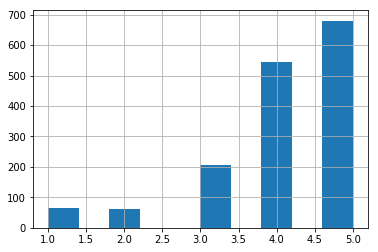

In [106]:
rev_user_biz_rf[~pred_rf]['rating_x'].astype(float).hist()

In [59]:
from sklearn.metrics import confusion_matrix

In [70]:
confusion_matrix(act, base35)

array([[3514,  347],
       [ 438,  149]])

In [71]:
confusion_matrix(act, base4)

array([[2687, 1174],
       [ 237,  350]])

In [72]:
confusion_matrix(act, pred_rf)

array([[1430, 2431],
       [ 128,  459]])

In [66]:
accuracy_score(~act_plus, ~base35), accuracy_score(~act_plus, ~base4), accuracy_score(~act_plus, ~pred_rf)

(0.6883992805755396, 0.6555755395683454, 0.5175359712230215)

Confusion matrix, without normalization


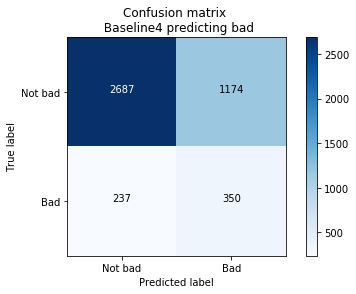

In [130]:
plot_confusion_matrix(confusion_matrix(act, base4),['Not bad','Bad'],
                      title='Confusion matrix \n Baseline4 predicting bad')

Confusion matrix, without normalization


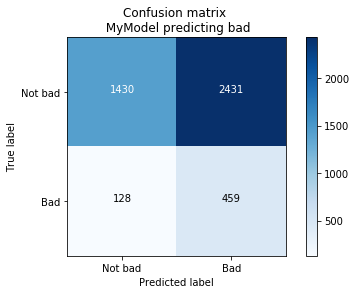

In [117]:
plot_confusion_matrix(confusion_matrix(act, pred_rf),['Not bad','Bad'],
                      title='Confusion matrix \n MyModel predicting bad')

Confusion matrix, without normalization


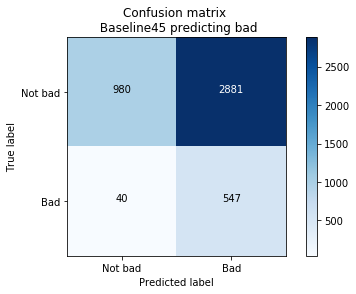

In [129]:
plot_confusion_matrix(confusion_matrix(act, base45),['Not bad','Bad'],
                      title='Confusion matrix \n Baseline45 predicting bad')

In [63]:
confusion_matrix(act_plus, base35)

array([[2801,  235],
       [1151,  261]])

Confusion matrix, without normalization


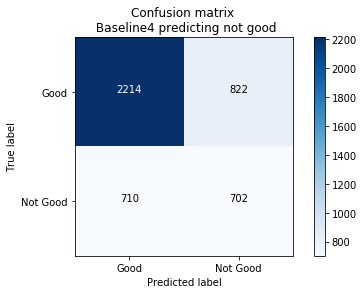

In [121]:
plot_confusion_matrix(confusion_matrix(act_plus, base4),['Good','Not Good'],
                      title='Confusion matrix \n Baseline4 predicting not good')

Confusion matrix, without normalization


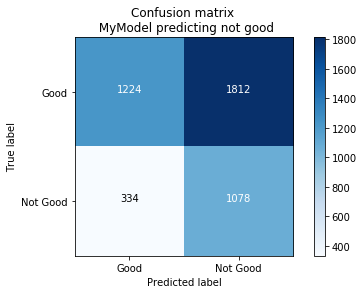

In [122]:
plot_confusion_matrix(confusion_matrix(act_plus, pred_rf),['Good','Not Good'],
                      title='Confusion matrix \n MyModel predicting not good')

Confusion matrix, without normalization


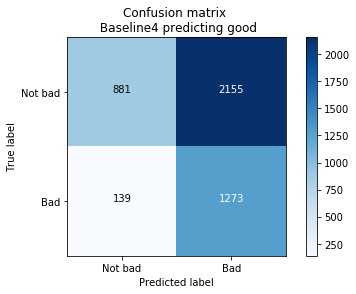

In [128]:
plot_confusion_matrix(confusion_matrix(act_plus, base45),['Not bad','Bad'],
                      title='Confusion matrix \n Baseline4 predicting bad')

 710/(710+2214), 334/(334+1224)

In [98]:
1078/(1412), 702/1412

(0.7634560906515581, 0.4971671388101983)

In [75]:
(precision_score(act_plus, base35),
 precision_score(act_plus, base4),
 
 precision_score(act_plus, pred_rf))

(0.5262096774193549, 0.46062992125984253, 0.37301038062283737)

### Summary after validation on real data

Random Forest models catch bad restaraunts better than base 35, base4, 
and in same time missed less really good restaraunts than base 4
    
With thresholds corresponding true positive rate 35 

In [238]:
rev_user_biz_gr['rating_x'].astype(float).mean(), rev_user_biz_gr['rating_x'].astype(float).std()

(3.778758620689655, 1.1139002849742248)

In [123]:
from src.z_test import z_test

Recall rf better than base_4

In [92]:
z_test(0.596252129471891, 0.7819420783645656, 587, 587, effect_size=0.12, two_tailed=False, alpha=.05)

z-score: 2.4313662316780165, p-value: 0.007521000789099452, reject null: True


(2.4313662316780165, 0.007521000789099452, True)

In [132]:
z_test( 0.7819420783645656, 547/587,587, 587, effect_size=0.1, two_tailed=False, alpha=.05)

z-score: 2.4420133712004164, p-value: 0.007302802825742694, reject null: True


(2.4420133712004164, 0.007302802825742694, True)

0.9318568994889267

Precision rf better than base4 if we measure how well catching  restaurants with rating less or equal 3

In [102]:
z_test(0.785622593068036,0.46062992125984253,  1524,2890, effect_size=0.05, two_tailed=False, alpha=.05)

z-score: 2.400050199688966, p-value: 0.008196411793859881, reject null: True


(2.400050199688966, 0.008196411793859881, True)

In [104]:
z_test(0.4971671388101983, 0.7634560906515581,  1412, 1412, effect_size=0.2, two_tailed=False, alpha=.05)

z-score: 3.6487822322496113, p-value: 0.00013174316562081234, reject null: True


(3.6487822322496113, 0.00013174316562081234, True)

In [78]:
tttt = Y_rf[['alias','rating']].copy()

In [84]:
tttt[:5].sort_values(by = 'rating', ascending=False)

,alias,rating
1,ohs-sandwiches-seattle-2,4.5
3,ittos-tapas-seattle-4,4.5
4,pizzeria-credo-seattle,4.5
0,maono-seattle,4.0
2,marination-ma-kai-seattle,4.0
